# Causal Inference for Precipitation vs. AQI

## Import package and data

In [1]:
import pandas as pd
import numpy as np
import re
import os
import urllib

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import geopandas as gpd

import os
import requests, zipfile, io

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 20)

In [2]:
air_quality = pd.read_csv('us_air_quality_measures.csv', ',')
daily_global_weather = pd.read_csv('daily_global_weather_2020.csv', ',')

In [3]:
!pip install reverse_geocoder

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

#import sys
#!{sys.executable} -m pip install reverse_geocoder

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import reverse_geocoder as rg

pd.set_option('mode.chained_assignment', None)


print(daily_global_weather["Unnamed: 0"].unique() == daily_global_weather.index.to_list())
daily_global_weather_new = daily_global_weather.drop(columns=["Unnamed: 0"])
daily_global_weather_new.head()


daily_global_weather_US = daily_global_weather_new[daily_global_weather_new["Station"].str[0:2] == "US"]
daily_global_weather_US.head()


daily_global_weather_US.loc[:, "TEMP_C"] = daily_global_weather_US.loc[:, "TAVG"] / 10.0

daily_global_weather_US["Datetime"] = pd.to_datetime(daily_global_weather_US["Date"], format="%Y-%m-%d")

daily_global_weather_US.loc[:, "PRCP_Millimeter"] = daily_global_weather_US.loc[:, "PRCP"] / 10.0

daily_global_weather_US_final = daily_global_weather_US[["Station", "Latitude", "Longitude",
                                                  "Elevation", "TEMP_C", "Datetime",
                                                  "PRCP_Millimeter"]]
daily_global_weather_US_final.head()


def visualize_uni_distribution(df, name, ax, trans=None):
    if trans is None:
        sns.distplot(df[name], ax=ax)
    elif trans == "log":
        eps = 1e-10
        sns.distplot(np.log10(df[name] + eps), ax=ax)


daily_global_weather_US_final["year"] = daily_global_weather_US_final["Datetime"].dt.year
daily_global_weather_US_final["month"] = daily_global_weather_US_final["Datetime"].dt.month
daily_global_weather_US_final["week"] = daily_global_weather_US_final["Datetime"].dt.week
daily_global_weather_US_final["day"] = daily_global_weather_US_final["Datetime"].dt.day

daily_global_weather_US_final.head()



geo_cord = []
geo_cord = list(daily_global_weather_US_final[['Latitude', 'Longitude']].itertuples(index=False, name=None))
# use rg to search
res = rg.search(geo_cord)

states, county = [], []
for i in res:
    states.append(i["admin1"])
    county.append(i["admin2"])

daily_global_weather_US_final["state"] = states
daily_global_weather_US_final["county"] = county
# daily_global_weather_US_final

[ True  True  True ...  True  True  True]
Loading formatted geocoded file...


## Data Preprocessing

In [5]:
# Get daily weather data (temp, precipitation) by county
weather_county = daily_global_weather_US_final
weather_county = weather_county[['county', 'Elevation', 'TEMP_C', 'Datetime', 'PRCP_Millimeter', 'year', 'month', 'week', 'day']].groupby(['county', 'Datetime']).mean().reset_index()
weather_county = weather_county[weather_county['county'] != '']
weather_county['county'] = weather_county['county'].str.rstrip(' County')
weather_county[['year', 'month', 'week', 'day']] = weather_county[['year', 'month', 'week', 'day']].astype('int32')
weather_county['Datetime'] = pd.to_datetime(weather_county['Datetime'])
weather_county

,county,Datetime,Elevation,TEMP_C,PRCP_Millimeter,year,month,week,day
296,Accomack,2020-01-02,11.6,4.4,0.0,2020,1,1,2
297,Accomack,2020-01-03,11.6,10.1,11.9,2020,1,1,3
298,Accomack,2020-01-04,11.6,12.1,16.5,2020,1,1,4
299,Accomack,2020-01-05,11.6,6.7,0.0,2020,1,1,5
300,Accomack,2020-01-06,11.6,3.8,0.0,2020,1,2,6
...,...,...,...,...,...,...,...,...,...
111367,Yellowstone,2020-10-18,1091.5,-4.9,9.7,2020,10,42,18
111368,Yellowstone,2020-10-19,1091.5,-3.4,13.5,2020,10,43,19
111369,Yellowstone,2020-10-20,1091.5,1.9,0.3,2020,10,43,20
111370,Yellowstone,2020-10-21,1091.5,0.4,1.5,2020,10,43,21


In [6]:
epa_weburl = "https://aqs.epa.gov/aqsweb/airdata/"
epa_filenames = pd.read_csv("epa_filenames.csv")
epa_filenames

,name,epa_filename
0,annual_county_aqi,annual_aqi_by_co...
1,daily_county_aqi,daily_aqi_by_cou...
2,daily_ozone,daily_44201_2020
3,daily_so2,daily_42401_2020
4,daily_co,daily_42101_2020
5,daily_no2,daily_42602_2020
6,daily_temp,daily_WIND_2020
7,daily_wind,daily_TEMP_2020
8,aqs_sites,aqs_sites


In [7]:
epa_data = {}
for name, filename in zip(epa_filenames['name'], epa_filenames['epa_filename']):
    path_name = 'data/{}'.format(name)
    if not os.path.isdir(path_name):
        data_url = '{}{}.zip'.format(epa_weburl, filename)
        req = requests.get(data_url)
        z = zipfile.ZipFile(io.BytesIO(req.content))
        z.extractall(path_name)
    data = pd.read_csv(f'data/{name}/{filename}.csv')
    epa_data[name] = data

In [8]:
# Add month and date
daily_county = epa_data.get('daily_county_aqi')
daily_county_datetime = pd.to_datetime(daily_county['Date'])
daily_county['Month'] = pd.DatetimeIndex(daily_county_datetime).month
daily_county['day'] = pd.DatetimeIndex(daily_county_datetime).day
daily_county['Date'] = pd.to_datetime(daily_county['Date'])

# Remove AQI outlier (recoreds with AQI > 500 area set to 500)
daily_county['AQI'] = daily_county['AQI'].apply(lambda x: 500 if x > 500 else x)

# Group by county and date to generate daily AQI data by county
daily_county = daily_county[['county Name', 'Date', 'AQI']].groupby(['county Name', 'Date']).mean().reset_index()
daily_aqi = daily_county
daily_aqi

,county Name,Date,AQI
0,Ada,2020-01-01,28.0
1,Ada,2020-01-02,30.0
2,Ada,2020-01-03,35.0
3,Ada,2020-01-04,33.0
4,Ada,2020-01-05,30.0
...,...,...,...
264703,Yuma,2020-12-27,32.0
264704,Yuma,2020-12-28,44.0
264705,Yuma,2020-12-29,38.0
264706,Yuma,2020-12-30,36.0


In [9]:
daily_wind = epa_data.get('daily_temp')
daily_wind['Date Local'] = pd.to_datetime(daily_wind['Date Local'])

In [10]:
daily_wind = daily_wind[['County Name', 'Date Local', '1st Max Hour']].groupby(['County Name', 'Date Local']).mean().reset_index()

In [11]:
daily_wind

,County Name,Date Local,1st Max Hour
0,Ada,2020-01-01,10.75
1,Ada,2020-01-02,14.75
2,Ada,2020-01-03,16.25
3,Ada,2020-01-04,10.00
4,Ada,2020-01-05,12.00
...,...,...,...
115817,Yolo,2020-12-27,20.50
115818,Yolo,2020-12-28,1.50
115819,Yolo,2020-12-29,10.00
115820,Yolo,2020-12-30,14.00


In [12]:
# Merge weather (temp, precipitation) with wind data
data_merged = pd.merge(weather_county, daily_wind, left_on=['county', 'Datetime'], right_on=['County Name', 'Date Local'])
data_merged

,county,Datetime,Elevation,TEMP_C,PRCP_Millimeter,year,month,week,day,County Name,Date Local,1st Max Hour
0,Ada,2020-01-01,1932.400000,-0.600000,7.60,2020,1,1,1,Ada,2020-01-01,10.75
1,Ada,2020-01-02,1395.050000,0.700000,1.25,2020,1,1,2,Ada,2020-01-02,14.75
2,Ada,2020-01-03,1395.050000,2.350000,0.00,2020,1,1,3,Ada,2020-01-03,16.25
3,Ada,2020-01-04,1395.050000,2.450000,1.25,2020,1,1,4,Ada,2020-01-04,10.00
4,Ada,2020-01-05,1395.050000,-1.150000,0.50,2020,1,1,5,Ada,2020-01-05,12.00
...,...,...,...,...,...,...,...,...,...,...,...,...
28165,Yakima,2020-10-18,1362.080000,7.820000,2.02,2020,10,42,18,Yakima,2020-10-18,6.50
28166,Yakima,2020-10-19,1362.080000,6.320000,0.00,2020,10,43,19,Yakima,2020-10-19,3.00
28167,Yakima,2020-10-20,838.800000,7.900000,0.00,2020,10,43,20,Yakima,2020-10-20,16.00
28168,Yakima,2020-10-21,1148.466667,1.966667,0.00,2020,10,43,21,Yakima,2020-10-21,10.00


In [13]:
# Merge with daily AQI data
data_merged = pd.merge(data_merged, daily_aqi, left_on=['county', 'Datetime'], right_on=['county Name', 'Date'])

In [14]:
# Add AQI shift (historical AQI data)
data = data_merged
data['prev_1'] = data.AQI.shift(1)
data['prev_2'] = data.AQI.shift(2)
data = data.dropna()
data

,county,Datetime,Elevation,TEMP_C,PRCP_Millimeter,year,month,week,day,County Name,Date Local,1st Max Hour,county Name,Date,AQI,prev_1,prev_2
2,Ada,2020-01-03,1395.050000,2.350000,0.00,2020,1,1,3,Ada,2020-01-03,16.25,Ada,2020-01-03,35.0,30.0,28.0
3,Ada,2020-01-04,1395.050000,2.450000,1.25,2020,1,1,4,Ada,2020-01-04,10.00,Ada,2020-01-04,33.0,35.0,30.0
4,Ada,2020-01-05,1395.050000,-1.150000,0.50,2020,1,1,5,Ada,2020-01-05,12.00,Ada,2020-01-05,30.0,33.0,35.0
5,Ada,2020-01-06,1395.050000,-1.050000,4.05,2020,1,2,6,Ada,2020-01-06,18.75,Ada,2020-01-06,33.0,30.0,33.0
6,Ada,2020-01-07,1395.050000,2.500000,0.00,2020,1,2,7,Ada,2020-01-07,12.50,Ada,2020-01-07,33.0,33.0,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27985,Yakima,2020-10-18,1362.080000,7.820000,2.02,2020,10,42,18,Yakima,2020-10-18,6.50,Yakima,2020-10-18,23.0,21.0,30.0
27986,Yakima,2020-10-19,1362.080000,6.320000,0.00,2020,10,43,19,Yakima,2020-10-19,3.00,Yakima,2020-10-19,15.0,23.0,21.0
27987,Yakima,2020-10-20,838.800000,7.900000,0.00,2020,10,43,20,Yakima,2020-10-20,16.00,Yakima,2020-10-20,30.0,15.0,23.0
27988,Yakima,2020-10-21,1148.466667,1.966667,0.00,2020,10,43,21,Yakima,2020-10-21,10.00,Yakima,2020-10-21,36.0,30.0,15.0


## Causal Inference

### Precipitation vs. AQI under different wind speed

In [15]:
data['wind_bucket'] = data['1st Max Hour'].apply(lambda x: int((x // 3) * 3))

Text(0, 0.5, 'Density')

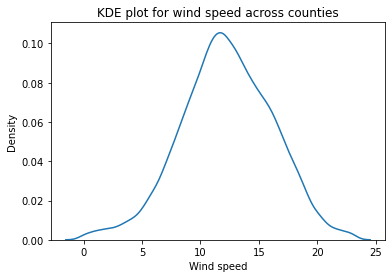

In [16]:
sns.kdeplot(data['1st Max Hour'])
plt.title('KDE plot for wind speed across counties')
plt.xlabel('Wind speed')
plt.ylabel('Density')

Text(0.5, 0, 'Precipitation (mm)')

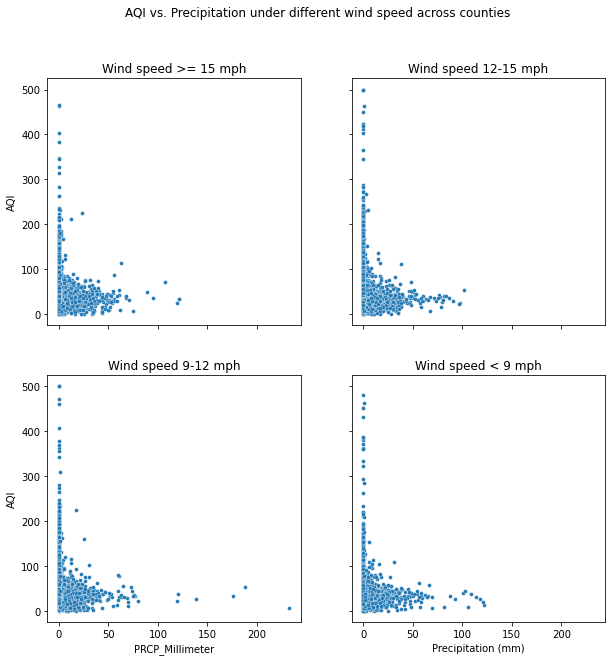

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
axes = axes.ravel()
fig.suptitle('AQI vs. Precipitation under different wind speed across counties')
sns.scatterplot(ax=axes[0], x='PRCP_Millimeter', y='AQI', data=data[data['wind_bucket'] >= 15], s=15)
axes[0].set_title('Wind speed >= 15 mph')
sns.scatterplot(ax=axes[1], x='PRCP_Millimeter', y='AQI', data=data[data['wind_bucket'] == 12], s=15)
axes[1].set_title('Wind speed 12-15 mph')
sns.scatterplot(ax=axes[2], x='PRCP_Millimeter', y='AQI', data=data[data['wind_bucket'] == 9], s=15)
axes[2].set_title('Wind speed 9-12 mph')
sns.scatterplot(ax=axes[3], x='PRCP_Millimeter', y='AQI', data=data[data['wind_bucket'] < 9], s=15)
axes[3].set_title('Wind speed < 9 mph')
plt.xlabel('Precipitation (mm)')

### Precipitation vs. AQI under different Temperature

In [18]:
data['TEMP_C_bucket'] = data['TEMP_C'].apply(lambda x: int((x // 10) * 10))

Text(0, 0.5, 'Density')

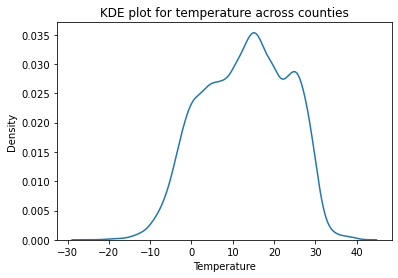

In [19]:
sns.kdeplot(data['TEMP_C'])
plt.title('KDE plot for temperature across counties')
plt.xlabel('Temperature')
plt.ylabel('Density')

Text(0.5, 0, 'Precipitation (mm)')

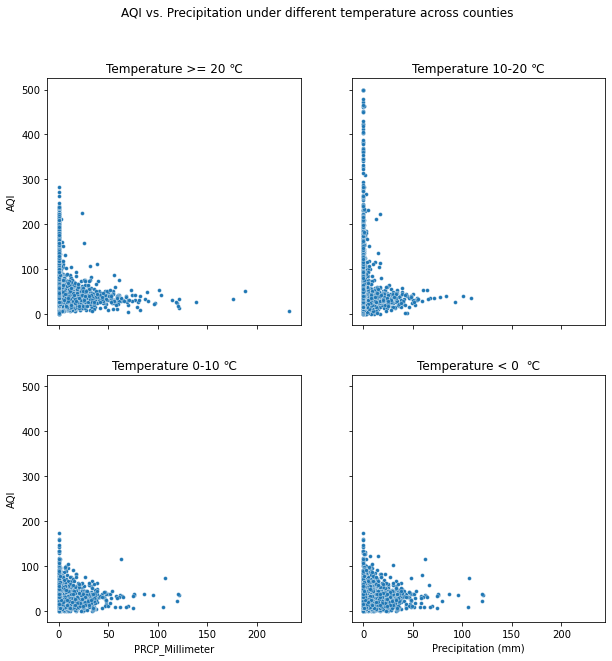

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)
axes = axes.ravel()
fig.suptitle('AQI vs. Precipitation under different temperature across counties')
sns.scatterplot(ax=axes[0], x='PRCP_Millimeter', y='AQI', data=data[data['TEMP_C_bucket'] >= 20], s=15)
axes[0].set_title('Temperature >= 20 ℃')
sns.scatterplot(ax=axes[1], x='PRCP_Millimeter', y='AQI', data=data[data['TEMP_C_bucket'] == 10], s=15)
axes[1].set_title('Temperature 10-20 ℃')
sns.scatterplot(ax=axes[2], x='PRCP_Millimeter', y='AQI', data=data[data['TEMP_C_bucket'] == 0], s=15)
axes[2].set_title('Temperature 0-10 ℃')
sns.scatterplot(ax=axes[3], x='PRCP_Millimeter', y='AQI', data=data[data['TEMP_C_bucket'] <= 0], s=15)
axes[3].set_title('Temperature < 0  ℃')
plt.xlabel('Precipitation (mm)')